# Notebook is run in kaggle's execution environment
This run needed ~15g gpu ram

In [1]:
!pip install tez
!pip install efficientnet-pytorch
!pip install timm

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=7a92859deb7af000feedc41b363b78307d324902a930883be5a453c251cd18ee
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
     |████████████████████████████████| 431 kB 596 kB/s            


In [2]:
import os

import albumentations
import numpy as np
import pandas as pd
import timm
import torch
import torch.nn as nn
from sklearn import metrics, model_selection
from PIL import Image, ImageFile

from tez import Tez, TezConfig
from tez.callbacks import EarlyStopping
from tez.utils import seed_everything

import matplotlib.pyplot as plt

In [3]:
class args:
    data_path = "../input/surfcrowd/surf-crowd/spot_populated_classification/data/classification_dataset.csv"
    model_name = "efficientnet_b0"
    learning_rate = 1.5e-3
    batch_size = 16
    epochs = 20
    output = "."
    accumulation_steps = 1

In [4]:
class SurfSpotDataset:
    def __init__(self, df, augmentations):
        self.df = df
        self.targets = df['class'].values
        self.df = self.df.drop(columns=["class"])
        self.augmentations = augmentations
        self.paths = self.df.path.apply(lambda x : "../input/surfcrowd/surf-crowd" + x.replace("\\","/")[2:]).values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        path = self.paths[item]
        targets = self.targets[item]
        
        image = Image.open(path)
        image = np.array(image)
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]            
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)

        image_tensor = torch.tensor(image)
        
        return {
            "image": image_tensor,
            "targets": torch.tensor(targets),
        }

In [5]:
class SurfSpotModel(nn.Module):
    def __init__(self, model_name, num_classes, loss, learning_rate, n_train_steps):
        super().__init__()

        self.learning_rate = learning_rate
        self.n_train_steps = n_train_steps
        self.model = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=num_classes,
        )
        self.loss = loss

    def monitor_metrics(self, outputs, targets):
        device = targets.get_device()
        outputs = (outputs.cpu().detach().numpy() > 0.5) * 1.
        targets = targets.cpu().detach().numpy()
        acc = metrics.accuracy_score(targets, outputs)
        f1 = metrics.f1_score(targets, outputs)
        mcc = metrics.matthews_corrcoef(targets, outputs)
        acc = torch.tensor(acc, device=device)
        f1 = torch.tensor(f1, device=device)
        mcc = torch.tensor(mcc, device=device)
        return {"accuracy": acc, "f1_score": f1, "mcc": mcc}

    def optimizer_scheduler(self):
        opt = torch.optim.SGD(
            self.parameters(),
            lr=self.learning_rate,
            momentum=0.9,
        )
        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt,
            factor=0.5,
            patience=2,
            verbose=True,
            mode="max",
            threshold=1e-4,
        )
        return opt, sch

    def forward(self, image, targets=None):
        x = self.model(image).squeeze(-1)
        if targets is not None:
            loss = self.loss(x, targets)
            metrics = self.monitor_metrics(x, targets)
            return x, loss, metrics
        return x, 0, {}

In [6]:
### seed_everything(42)
df = pd.read_csv(args.data_path)
    
train_aug = albumentations.Compose(
    [        
        albumentations.HorizontalFlip(p=0.5),
        albumentations.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.12),
        albumentations.RandomBrightnessContrast(brightness_limit=(-0.15, 0.15), contrast_limit=(-0.18, 0.18), p=0.2),
        albumentations.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0,
        ),
        albumentations.augmentations.geometric.resize.LongestMaxSize(
            max_size=1240
        ),
    ],
    p=1.0,
)

valid_aug = albumentations.Compose(
    [
        albumentations.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0,
        ),
        albumentations.augmentations.geometric.resize.LongestMaxSize(
            max_size=1240
        ),
    ],
    p=1.0,
)

# some images were corrupted but still annotated
to_drop = []
paths = df.path.apply(lambda x : "../input/surfcrowd/surf-crowd" + x.replace("\\","/")[2:]).values
for i in range(len(paths)):
    image = Image.open(paths[i])
    image = np.array(image)
    try:
        augmented = train_aug(image=image)
        image = augmented["image"]    
    except Exception:
        to_drop.append(i)
        print("to drop : ", i)
    else:
        pass
df = df.drop(to_drop)

train_df, valid_df = model_selection.train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["class"].values,
)

train_dataset = SurfSpotDataset(
    df=train_df,
    augmentations=train_aug,
)
valid_dataset = SurfSpotDataset(
    df=valid_df,
    augmentations=valid_aug,
)

to drop :  196
to drop :  320
to drop :  633


torch.Size([3, 698, 1240])
tensor(0., dtype=torch.float64)


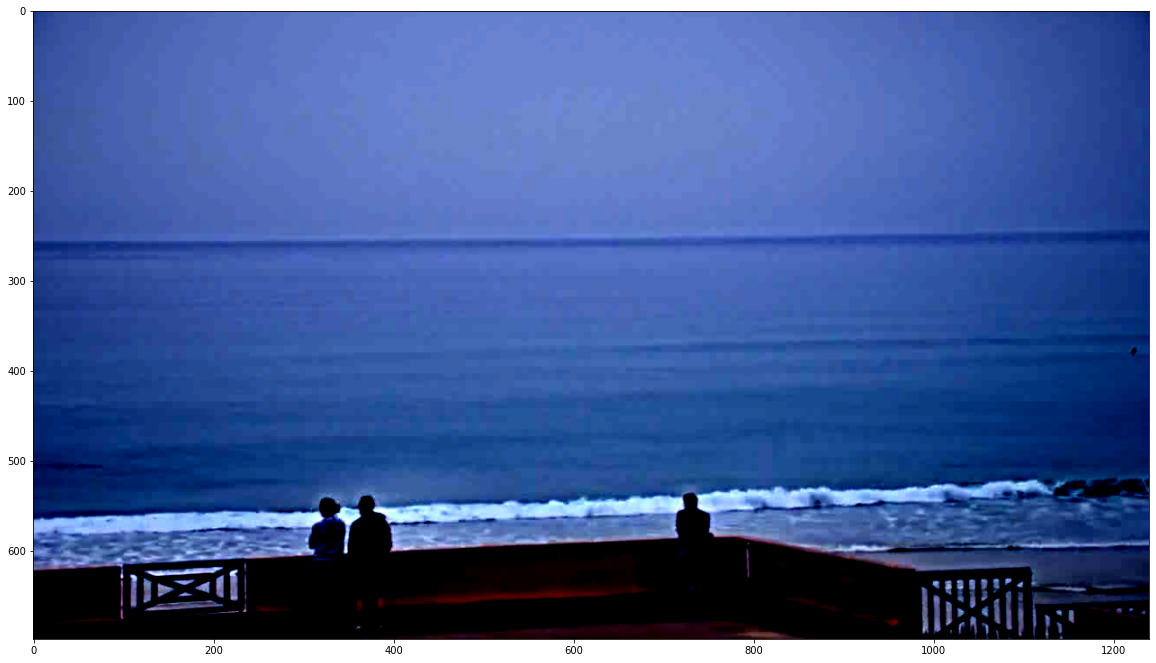

In [7]:
idx = 1083
print(train_dataset[idx]["image"].shape)
plt.rcParams["figure.figsize"] = (20,16)
plt.imshow(train_dataset[idx]["image"].permute(1, 2, 0))
plt.rcParams["figure.figsize"] = (5,5)
print(train_dataset[idx]["targets"])

In [8]:
counts = train_df["class"].value_counts().values
weight = counts[0]/counts[1]
loss = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([weight]).to('cuda'))

In [9]:
n_train_steps = int(len(train_dataset) / args.batch_size / args.accumulation_steps * args.epochs)
model = SurfSpotModel(
    model_name=args.model_name,
    num_classes=1,
    loss=loss,
    learning_rate=args.learning_rate,
    n_train_steps=n_train_steps,
)

model = Tez(model)
config = TezConfig(
    training_batch_size=args.batch_size,
    validation_batch_size=2 * args.batch_size,
    test_batch_size=2 * args.batch_size,
    gradient_accumulation_steps=args.accumulation_steps,
    epochs=args.epochs,
    step_scheduler_after="epoch",
    step_scheduler_metric="valid_accuracy",
    fp16=True,
)

es = EarlyStopping(
    monitor="valid_accuracy",
    model_path=os.path.join(args.output, "model.bin"),
    patience=10,
    mode="max",
    save_weights_only=True,
)

model.fit(
    train_dataset,
    valid_dataset=valid_dataset,
    callbacks=[es],
    config=config,
)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth
2022-04-03 17:18:30,668 INFO Using single GPU


  0%|          | 0/1452 [00:00<?, ?it/s]

2022-04-03 17:18:30,712 INFO 
TezConfig(device='cuda', training_batch_size=16, validation_batch_size=32, test_batch_size=32, epochs=20, gradient_accumulation_steps=1, clip_grad_norm=-1, num_jobs=2, fp16=True, train_shuffle=True, valid_shuffle=True, train_drop_last=False, valid_drop_last=False, test_drop_last=False, test_shuffle=False, pin_memory=True, step_scheduler_after='epoch', step_scheduler_metric='valid_accuracy', val_strategy='epoch', val_steps=100)


[train e=0] accuracy: 0.6661, f1_score: 0.5547, mcc: 0.3165, loss: 1.1842
[valid e=0] accuracy: 0.6333, f1_score: 0.6440, mcc: 0.2982, loss: 1.2706
[train e=1] accuracy: 0.8296, f1_score: 0.7819, mcc: 0.6656, loss: 0.6473
[valid e=1] accuracy: 0.8104, f1_score: 0.6780, mcc: 0.5645, loss: 0.6257
[train e=2] accuracy: 0.8656, f1_score: 0.8272, mcc: 0.7395, loss: 0.4250
[valid e=2] accuracy: 0.7740, f1_score: 0.7508, mcc: 0.5216, loss: 0.7786
[train e=3] accuracy: 0.9092, f1_score: 0.8786, mcc: 0.8241, loss: 0.3063
[valid e=3] accuracy: 0.8500, f1_score: 0.7898, mcc: 0.6850, loss: 0.6553
[train e=4] accuracy: 0.9413, f1_score: 0.9238, mcc: 0.8843, loss: 0.1836
[valid e=4] accuracy: 0.8448, f1_score: 0.7376, mcc: 0.6477, loss: 0.8887
[train e=5] accuracy: 0.9507, f1_score: 0.9343, mcc: 0.9027, loss: 0.1501
[valid e=5] accuracy: 0.8260, f1_score: 0.7651, mcc: 0.6451, loss: 0.7235
[train e=6] accuracy: 0.9623, f1_score: 0.9494, mcc: 0.9233, loss: 0.1295
[valid e=6] accuracy: 0.8781, f1_score